<a href="https://www.kaggle.com/code/robertgrantham/austin-crime-reports-analysis?scriptVersionId=147856515" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Analyzing Austin PD's Crime Reports Dataset

The Austin Police Department's Crime Reports dataset provides valuable information about reported crimes in Austin, Texas. In this analysis, we will explore the dataset and gain insights into various aspects of crime in Austin.

## Table of Contents

I. Introduction  
II. Data  
III. Methodology  
IV. Outcome  

## I. Introduction

The Austin Police Department's Crime Reports dataset offers a comprehensive view of reported crimes in Austin, Texas. By analyzing this dataset, we can extract valuable insights into the nature and patterns of crime in the city.

## II. Data

### 1. Project Context

This project is self-paced and not affiliated with any work or educational institution. My goal is to uncover valuable insights that can benefit the Austin law enforcement community, news outlets, and anyone interested in understanding and addressing crime-related issues in the Austin area.

### 2. Data Collection

Initially, I attempted to import the data into this notebook using Sodapy's Socrata API method. However, I found it to be insufficient as it didn't import the complete dataset and added redundant columns. As a result, I decided to manually download the entire dataset and repeat the process each week after the updates.

### 3. Data Scrubbing

Before conducting any analysis, it is crucial to clean and preprocess the dataset. The data scrubbing process involves addressing missing data, removing irrelevant columns, and ensuring data types are appropriate.

## III. Methodology

Once the dataset is scrubbed and prepared, we can perform an exploratory analysis to gain a deeper understanding of the crime data. The exploratory analysis may include the following:

### A. Crime Rates by Area

#### 1. Crime Rates by Zip Code

We start by examining the crime rates by zip code. The following code calculates the total number of crimes for each zip code and displays the top 10 zip codes with the highest crime rates.

```python
crime_by_zipcode = df["zip_code"].value_counts().head(10).to_frame()
display(crime_by_zipcode)
```

#### 2. Crime Rates as Percentages

In addition to the total crime counts, it is also informative to analyze the crime rates as percentages relative to the total. The following code calculates the crime rates as percentages for each zip code and displays the top 10 zip codes with the highest crime rates.

```python
crime_rates_by_zipcode = df["zip_code"].value_counts(normalize=True).head(10).to_frame()
display(crime_rates_by_zipcode)
```

#### 3. Visualizing Crime Rates by Zip Code

To visually represent the crime rates by zip code, we can create a bar chart. The following code generates a bar chart showing the top 10 zip codes with the highest crime rates.

```python
plt.figure(figsize=(10, 6))
crime_by_zipcode.plot(kind="bar", rot=45)
plt.title("Top 10 Zip Codes with Highest Crime Rates")
plt.xlabel("Zip Code")
plt.ylabel("Number of Crimes")
plt.show()
```

## IV. Outcome

In this section, we summarize the key findings and insights obtained from the analysis. Discuss any significant patterns, trends, or observations related to crime in Austin based on the data and methodologies applied.

By analyzing the crime data, we aim to contribute to a better understanding of crime distribution, trends, and areas of concern in Austin. This information can be valuable for law enforcement agencies, policymakers, and the community in efforts to address and prevent crime effectively.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium import plugins
from geopy.distance import geodesic
from sklearn.cluster import KMeans
import seaborn as sns
import warnings

# Constants
OUTPUT_DIRECTORY = "crime_analysis_outputs"
BOOKING_OFFICE_COORDS = (30.274020, -97.746580)  # Latitude, Longitude

# Set up pandas and seaborn
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
plt.style.use("seaborn-white")
sns.set_style("whitegrid")
os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)


In [2]:
def load_data(file_path):
    """
    Load data from a CSV file.

    Parameters:
    - file_path (str): Path to the CSV file.

    Returns:
    - pd.DataFrame: The loaded DataFrame or None if an error occurs.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        print("Error loading data:", e)
        return None


def calculate_distance_to_booking_office(df):
    """
    Calculate the distance from each crime location to the booking office.

    Parameters:
    - df (pd.DataFrame): DataFrame containing latitude and longitude columns.

    Returns:
    - pd.DataFrame: Original DataFrame with a new 'Distance to Booking Office' column.
    """
    # Drop rows with NaN values in latitude and longitude columns
    df = df.dropna(subset=["Latitude", "Longitude"])

    # Calculate the distance for the remaining rows
    df["Distance to Booking Office (Miles)"] = df.apply(
        lambda row: geodesic(
            (row["Latitude"], row["Longitude"]), BOOKING_OFFICE_COORDS
        ).miles,
        axis=1,
    )
    return df


In [3]:
def clean_data(df):
    """
    Clean and preprocess the DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    - pd.DataFrame: The cleaned DataFrame.
    """
    # Drop unnecessary columns
    columns_to_drop = [
        "X-coordinate",
        "Y-coordinate",
        "Location",
    ]
    df = df.drop(columns=columns_to_drop, errors="ignore")

    # Convert date and time columns to datetime
    date_time_columns = ["Occurred Date Time", "Report Date Time", "Clearance Date"]
    for col in date_time_columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")
    # Handle missing values
    df.fillna(
        {
            "Zip Code": "Unknown",
            "Location Type": "Unknown",
            "Council District": "Unknown",
            "PRA": "Unknown",
            "Census Tract": "Unknown",
            "APD Sector": "Unknown",
            "APD District": "Unknown",
            "Clearance Status": "Unknown",
            "Category Description": "Unknown",
        },
        inplace=True,
    )

    # Convert columns to categorical
    categorical_columns = [
        "Highest Offense Description",
        "Zip Code",
        "Location Type",
        "Council District",
        "APD District",
        "APD Sector",
        "PRA",
        "Census Tract",
        "Category Description",
    ]
    df[categorical_columns] = df[categorical_columns].astype("category")

    # Extract date-related features
    df["Year"] = df["Occurred Date Time"].dt.year
    df["Quarter"] = df["Occurred Date Time"].dt.quarter
    df["Month"] = df["Occurred Date Time"].dt.month
    df["Day"] = df["Occurred Date Time"].dt.day
    df["Day of Week"] = df["Occurred Date Time"].dt.dayofweek

    # Create dummy variables for the day of the week
    day_of_week_dummies = pd.get_dummies(
        df["Day of Week"], prefix="Day", drop_first=True
    )
    df = pd.concat([df, day_of_week_dummies], axis=1)

    # Set 'Occurred Date Time' as the index
    df.set_index("Occurred Date Time", inplace=True)
    df.sort_index(inplace=True)

    # Calculate time to clearance
    df["Time to Clearance (Days)"] = (
        df["Clearance Date"] - df["Report Date Time"]
    ).dt.days

    return df


In [4]:
def filter_and_save_data(df, filter_condition, filename):
    """
    Filter the DataFrame based on a condition and save it to a CSV file.

    Parameters:
    - df (pd.DataFrame): The input DataFrame to be filtered.
    - filter_condition (str): The condition to filter the DataFrame.
    - filename (str): The name of the CSV file to save the filtered data.
    """
    filtered_data = df.query(filter_condition)
    filtered_data.to_csv(filename, index=False)


def plot_bar_graph(data, x_label, y_label, title, filename):
    """
    Plot a bar graph.

    Parameters:
    - data (pd.Series): Data to be plotted.
    - x_label (str): Label for the x-axis.
    - y_label (str): Label for the y-axis.
    - title (str): Title of the plot.
    - filename (str): Name of the file to save the plot.
    """
    plt.figure(figsize=(12, 6))
    data.plot(kind="bar", rot=60)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.savefig(filename)


def create_heatmap(df, outfile):
    """
    Create a heatmap of crime locations.

    Parameters:
    - df (pd.DataFrame): DataFrame containing latitude and longitude columns.
    - outfile (str): Name of the HTML file to save the heatmap.
    """
    coords_heat = df[["Latitude", "Longitude"]].dropna()
    map_austin = folium.Map(
        location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12
    )
    map_austin.add_child(plugins.HeatMap(coords_heat.values, radius=15))
    map_austin.save(outfile)


def cluster_crime_locations(df, n_clusters):
    """
    Cluster crime locations into n_clusters using K-means.

    Parameters:
    - df (pd.DataFrame): DataFrame containing 'Latitude' and 'Longitude' columns.
    - n_clusters (int): Number of clusters to create.

    Returns:
    - pd.DataFrame: Original DataFrame with a new 'Location Cluster' column.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    df["Location Cluster"] = kmeans.fit_predict(df[["Latitude", "Longitude"]])
    return df


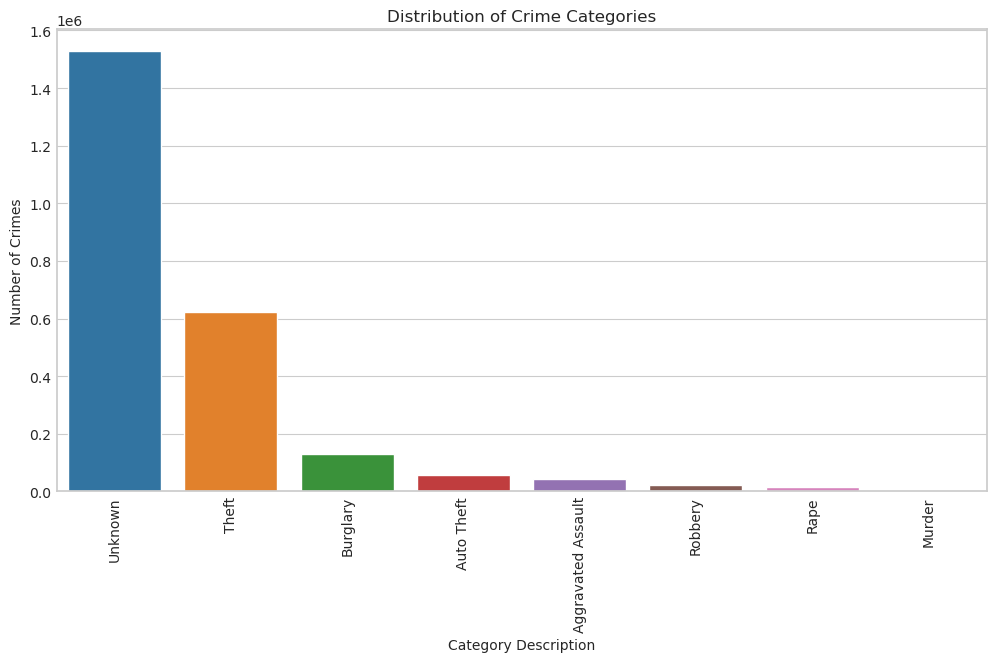

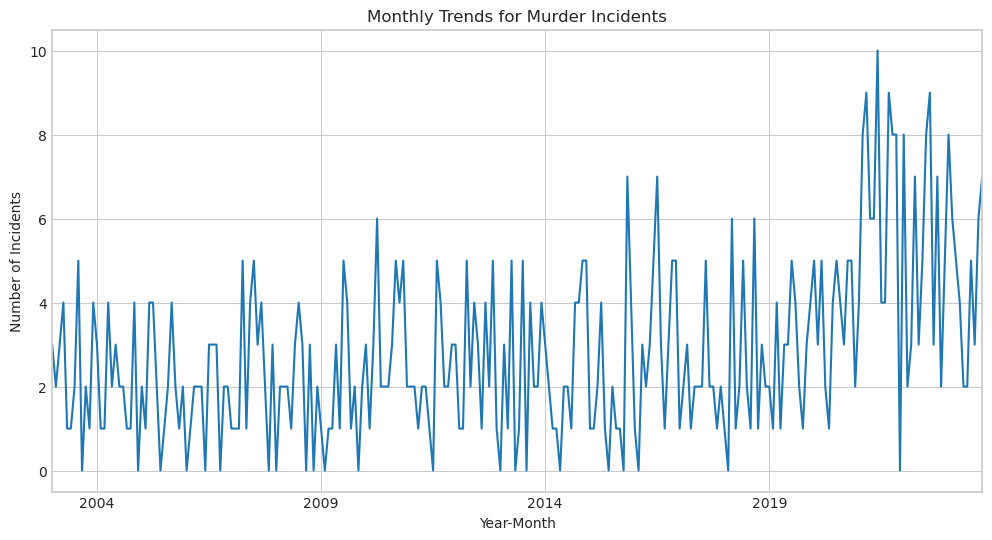

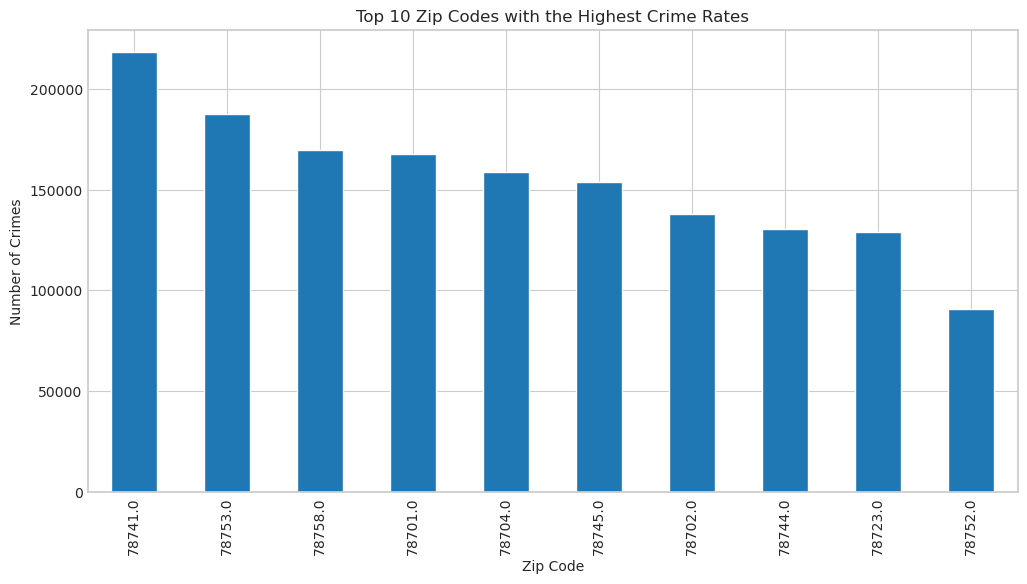

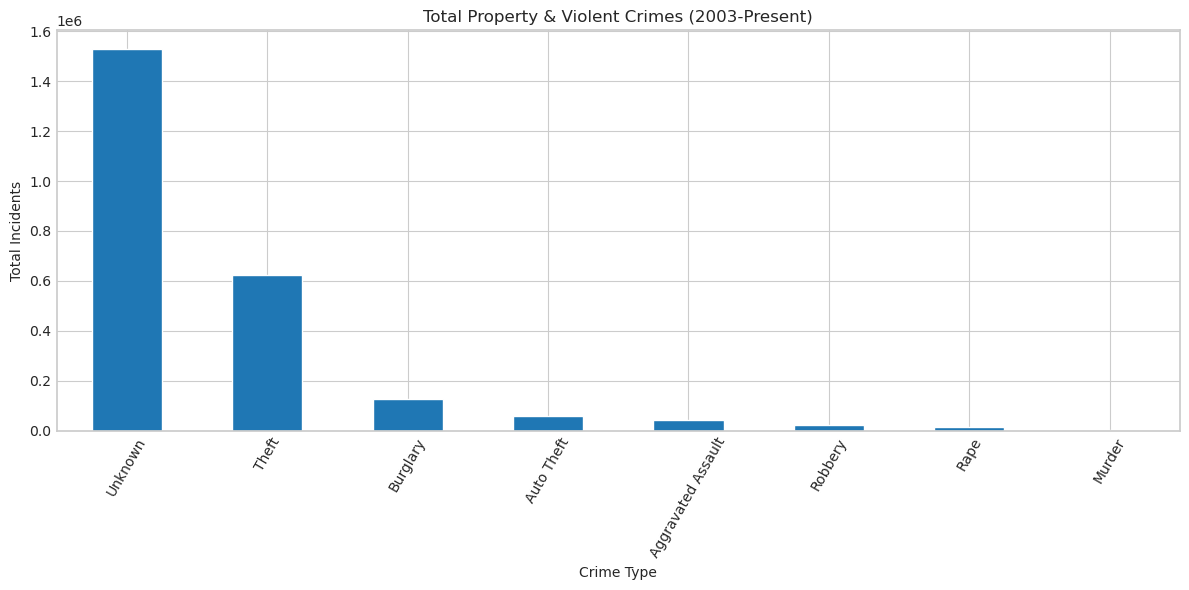

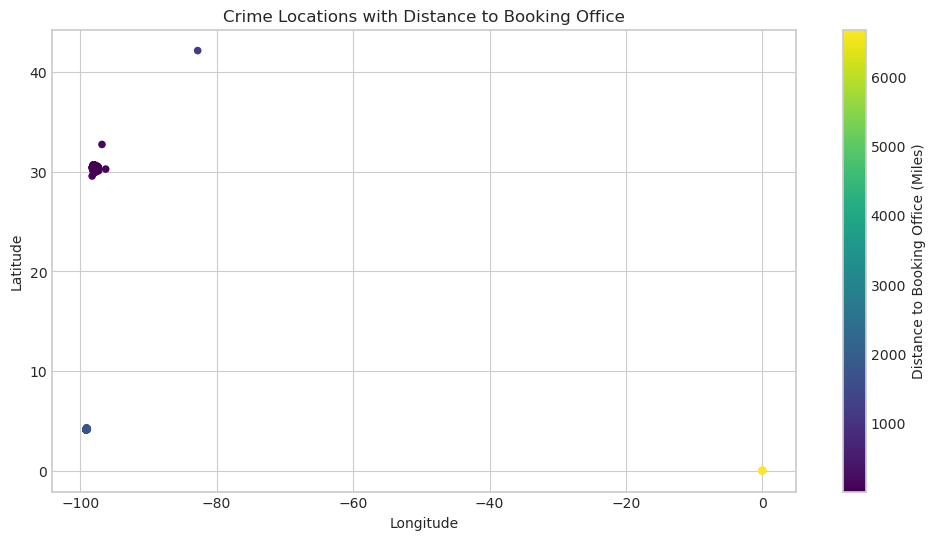

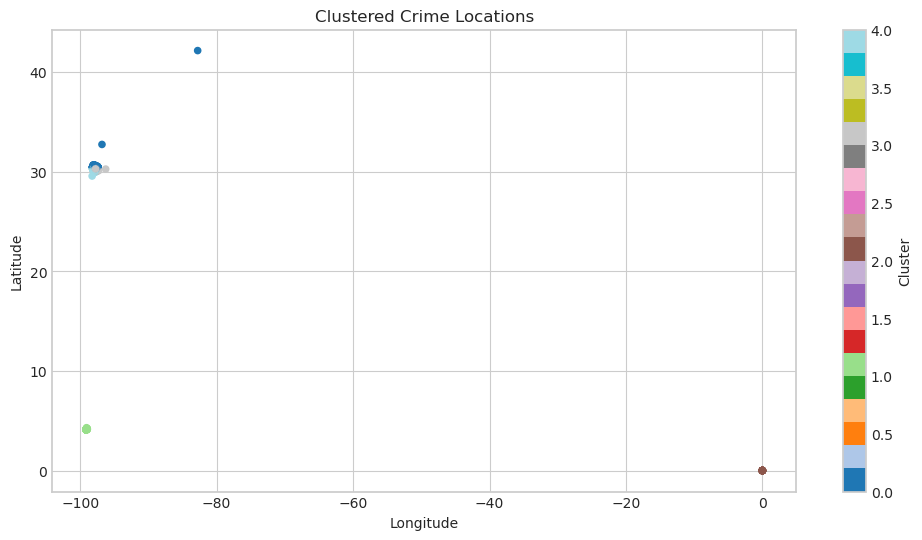

In [5]:
# Load the data
file_path = "/kaggle/input/10232023/Crime_Reports.csv"
data = load_data(file_path)

if data is not None:
    data = clean_data(data)

    # Additional data analysis and visualizations can be performed here.

    # Data Summary and Cleaning
    # Display basic statistics of the dataset
    data_description = data.describe()

    # Check for missing values
    missing_values = data.isnull().sum()

    # Handle missing values based on data_description and domain knowledge
    # Example: Handling missing values in 'Clearance Status'
    data["Clearance Status"].fillna("Not Cleared", inplace=True)

    # Safely get Latitude and Longitude columns with default values
    latitude = data.get("Latitude", 0.0)
    longitude = data.get("Longitude", 0.0)

    # Crime Categories Analysis
    # Calculate the frequency of each crime category
    crime_category_counts = data["Category Description"].value_counts()

    # Explore the distribution of crimes based on categories
    plt.figure(figsize=(12, 6))
    sns.countplot(
        data=data, x="Category Description", order=crime_category_counts.index
    )
    plt.title("Distribution of Crime Categories")
    plt.xlabel("Category Description")
    plt.ylabel("Number of Crimes")
    plt.xticks(rotation=90)
    plt.show()

    # Investigate trends and patterns in the "Murder" crime category
    specific_category = "Murder"
    category_trends = data[data["Category Description"] == specific_category]

    # Create a time series plot for the "Murder" category
    plt.figure(figsize=(12, 6))
    category_trends.resample("M")["Category Description"].count().plot()
    plt.title(f"Monthly Trends for {specific_category} Incidents")
    plt.xlabel("Year-Month")
    plt.ylabel("Number of Incidents")
    plt.show()

    # Location Analysis
    # Examine the crime rates by zip code
    crime_by_zipcode = data["Zip Code"].value_counts()

    # Calculate crime rates as percentages relative to the total
    crime_rates_by_zipcode = data["Zip Code"].value_counts(normalize=True)

    # Create a bar chart to represent location-based insights
    plt.figure(figsize=(12, 6))
    crime_by_zipcode.head(10).plot(kind="bar")
    plt.title("Top 10 Zip Codes with the Highest Crime Rates")
    plt.xlabel("Zip Code")
    plt.ylabel("Number of Crimes")
    plt.show()

    # Example: Plot total property and violent crimes
    plot_bar_graph(
        data["Category Description"].value_counts(),
        "Crime Type",
        "Total Incidents",
        "Total Property & Violent Crimes (2003-Present)",
        "total_crimes.png",
    )

    # Calculate distance to the booking office and cluster crime locations
    data = calculate_distance_to_booking_office(data)
    data = cluster_crime_locations(data, n_clusters=5)

    # Create a scatter plot for the distance to booking office
    plt.figure(figsize=(12, 6))
    plt.scatter(
        data["Longitude"],
        data["Latitude"],
        c=data["Distance to Booking Office (Miles)"],
        cmap="viridis",
        s=20,
    )
    plt.title("Crime Locations with Distance to Booking Office")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Distance to Booking Office (Miles)")
    plt.show()

    # Create a scatter plot for clustered crime locations
    plt.figure(figsize=(12, 6))
    plt.scatter(
        data["Longitude"],
        data["Latitude"],
        c=data["Location Cluster"],
        cmap="tab20",
        s=20,
    )
    plt.title("Clustered Crime Locations")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Cluster")
    plt.show()

    # Generate heatmaps for different crime types
    crime_categories = ["Aggravated Assault", "Robbery", "Murder"]
    for category in crime_categories:
        create_heatmap(
            data[data["Category Description"] == category],
            f"{category.lower().replace(' ', '_')}_heatmap.html",
        )
    # Display plots and results
    plt.show()
